In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from random import shuffle
from copy import deepcopy
import networkx as nx

In [2]:
class siRNN(nn.Module):
    def __init__(self, nin, nnode, nout, x0, dtRtau=0.1):
        # x0 must be a variable
        super(siRNN, self).__init__()
        self.l11 = nn.Linear(nin, nnode) # BU + b
        self.l12 = nn.Linear(nnode, nnode, bias=False) #J Y_i-1
        self.x = x0 #initialize states. x0 should be a tensor/variable?
        self.dtRtau = dtRtau
        self.lout = nn.Linear(nnode, nout) # Output of the network
    
    def forward(self, u):
        # u must be a variable
        self.r = F.tanh(self.x) # Output of each neuron in terms of firing/not firing
        self.x = self.x*(1-self.dtRtau) + self.dtRtau*(self.l11(u) + self.l12(self.r))
        #self.output = F.tanh(self.lout(self.x))
        self.output = self.lout(self.x)
        return self.output, self.x, self.r
    
    def weight_init(self):
        nn.init.sparse(self.l12.weight, sparsity=0.1, std=0.01)
    
    def state_reset(self, x0):
        self.x = x0

In [4]:
# Training set

# u = [uc, um, ucc, ucm]T
# ucc, ucm are either 0 or 1
# Motion context: ucm = 1, ucc=0
# Color context: ucm = 0, ucc=1
# uc = um = d + rho

# rho: Noise, zero-mean, std=1
# d: offset. uniform between [0, 0.1875]

# First pick d from a uniform([-0.1875, +0.1875]) and then identify the appropriate
# target. 

# Convert both to time-series. with the correct protocol.
# input: 1ms in the begining, size 2
# target: 1ms to 0 in the beginning. 1ms to correct choice at T.

# N of trials: 160000

#trial_1 
dt = 1 # in ms
trial_len = 750*dt
#trial_len = 200*dt
ntrials = 1000 

train_data = []


for i in range(ntrials):
    rho_temp = np.random.normal(0, 1, size=trial_len) # noise @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    #rho_temp = np.random.normal(0, 0.1, size=trial_len) # noise @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    dc_temp = np.random.uniform(-0.1875, 0.1875)
    uc_temp = dc_temp + rho_temp
    dm_temp = np.random.uniform(-0.1875, 0.1875)
    um_temp = dm_temp + rho_temp
    
    # Target only depends on the movement direction
    target_temp = np.sign(dm_temp)
    
    if i < (ntrials/2):
        ucc_temp,ucm_temp = 0,1
    else:
        ucc_temp,ucm_temp = 1,0
        
    u_temp = [uc_temp, um_temp, ucc_temp, ucm_temp]
    train_data.append([u_temp , target_temp])

shuffle(train_data)

In [5]:
## Creating an instance
nin = 4
nnode = 100
#nnode = 50
nout = 1
#x0 = Variable(torch.randn(nnode).cuda())
x0 = Variable(torch.randn(nnode))
myrnn = siRNN(nin, nnode, nout, x0)
#myrnn.cuda()
myrnn.weight_init()

In [6]:
# Training with BP during the whole trial
lr = 0.0003
optimizer = optim.Adam(myrnn.parameters(), lr = lr)
criterion = nn.L1Loss()

#zero = Variable(torch.cuda.FloatTensor([0]))
#zero = Variable(torch.FloatTensor([0]))

allloss =[]
alloutput =[]
alltarget = []

for i, trial in enumerate(train_data):
    u = trial[0]
    u[2] = u[2]*np.ones_like(u[0])
    u[3] = u[3]*np.ones_like(u[0])
    #input = Variable(torch.cuda.FloatTensor(u))
    #target = Variable(torch.cuda.FloatTensor([trial[1]]))
    input = Variable(torch.FloatTensor(u))
    target = Variable(torch.FloatTensor([trial[1]]))
    
    #alloutput, allxn, allrn =[], [], []
    myrnn.state_reset(x0)
    for t in range(input.shape[1]):
        output, xn, rn = myrnn(input[:,t])
        #alloutput.append(output.data.numpy())
        #allxn.append(xn.data.numpy())
        #allrn.append(rn.data.numpy())
        #if t==0:
            #optimizer.zero_grad()
            #loss1 = criterion(output, zero)
            #loss1.backward(retain_graph=True)
            #optimizer.step()
        if t>input.shape[1]/1.1:
            optimizer.zero_grad()
            loss2 = criterion(output, target)
            loss2.backward(retain_graph=True)
            optimizer.step()
            
    alloutput.append(output.data)    
    alltarget.append(target.data)
    allloss.append(loss2.data)
    if i%10 ==0:
        print(i," out of ", ntrials, " trials processed. Loss=", loss2)

0  out of  1000  trials processed. Loss= Variable containing:
 0.3853
[torch.FloatTensor of size 1]

10  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  7.1897
[torch.FloatTensor of size 1]

20  out of  1000  trials processed. Loss= Variable containing:
 0.3786
[torch.FloatTensor of size 1]

30  out of  1000  trials processed. Loss= Variable containing:
 0.2359
[torch.FloatTensor of size 1]

40  out of  1000  trials processed. Loss= Variable containing:
 0.1047
[torch.FloatTensor of size 1]

50  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  1.3416
[torch.FloatTensor of size 1]

60  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  8.3624
[torch.FloatTensor of size 1]

70  out of  1000  trials processed. Loss= Variable containing:
 0.1385
[torch.FloatTensor of size 1]

80  out of  1000  trials processed. Loss= Variable containing:
 0.1749
[torch.FloatTensor of size 1]

90  out of  1000  trials processed. Lo

750  out of  1000  trials processed. Loss= Variable containing:
 0.9014
[torch.FloatTensor of size 1]

760  out of  1000  trials processed. Loss= Variable containing:
 0.6677
[torch.FloatTensor of size 1]

770  out of  1000  trials processed. Loss= Variable containing:
 0.1535
[torch.FloatTensor of size 1]

780  out of  1000  trials processed. Loss= Variable containing:
 1.1237
[torch.FloatTensor of size 1]

790  out of  1000  trials processed. Loss= Variable containing:
 0.1256
[torch.FloatTensor of size 1]

800  out of  1000  trials processed. Loss= Variable containing:
 0.2848
[torch.FloatTensor of size 1]

810  out of  1000  trials processed. Loss= Variable containing:
 0.2441
[torch.FloatTensor of size 1]

820  out of  1000  trials processed. Loss= Variable containing:
 0.1843
[torch.FloatTensor of size 1]

830  out of  1000  trials processed. Loss= Variable containing:
1.00000e-02 *
  4.3051
[torch.FloatTensor of size 1]

840  out of  1000  trials processed. Loss= Variable contai

In [7]:
# Save the model
torch.save(myrnn.state_dict(), 'siRNNfinNull')
# Load the trained model to catch up with work.
#den_net.load_state_dict(torch.load('siRNN23'))

Performance =  96.4 %


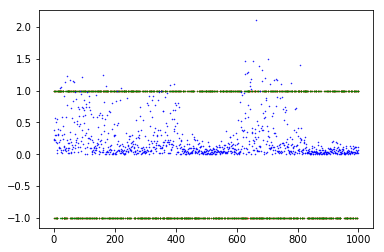

In [9]:
n_ax = range(len(alloutput))
alloutput=np.asarray(alloutput)
alltarget=np.asarray(alltarget)
allloss=np.asarray(allloss)

perf=100*np.sum(allloss<1)/len(allloss)
print("Performance = ",perf, "%")
plt.plot(n_ax, np.sign(alloutput), '.r', n_ax, alltarget,'.g', allloss, '.b', markersize=1)
plt.savefig('siRNNfinNull-result',dpi=300,format='pdf')

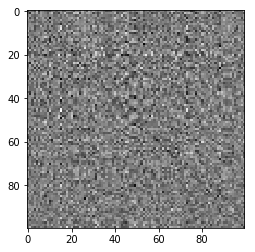

In [10]:
str_conn = myrnn.l12.weight.data.numpy()
plt.imshow(str_conn, cmap='gray')

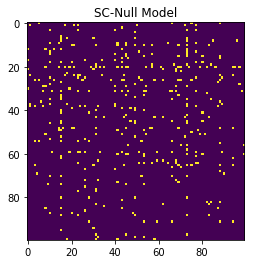

In [17]:
str_conn_abs = np.abs(deepcopy(str_conn))
thresh=0.14
str_conn_b = np.abs(deepcopy(str_conn_abs))
str_conn_b[str_conn_abs<thresh]=0
str_conn_b[str_conn_abs>=thresh]=1
plt.imshow(str_conn_b)
plt.title('SC-Null Model')

/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/N/soft/rhel6/anaconda3/4.4.0/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0


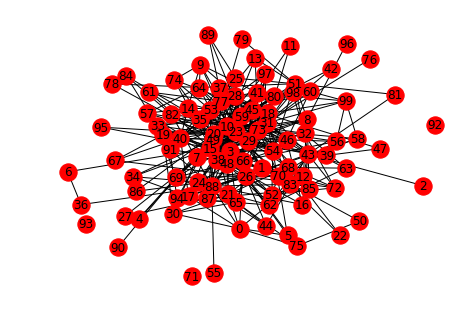

In [16]:
D = nx.DiGraph(str_conn_b)
D_un = nx.Graph(D)  # convert D to undirected graph
#D_un.remove_node(72)
nx.draw(D_un, with_labels=True)